# Demo of scikit-learn models

In [1]:
import pandas as pd
import pathlib
import arviz as az
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
export_images = False

## Synthetic control

In [5]:
sc_data_path = (
    pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "synthetic_control.csv"
)
df = pd.read_csv(sc_data_path)
treatment_time = 70

First we use a common model where regression coefficients are constrained to the interval [0, 1] and to sum to 1. This uses a custom `WeightedProportion` class.

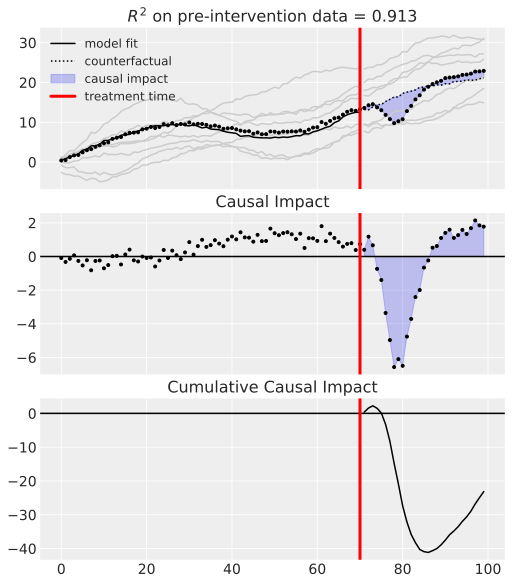

In [6]:
from causalpy.skl_models import WeightedProportion
from causalpy.skl_experiments import SyntheticControl

# Note, we do not want an intercept in this model
thing = SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    prediction_model=WeightedProportion(),
)

fig, ax = thing.plot()

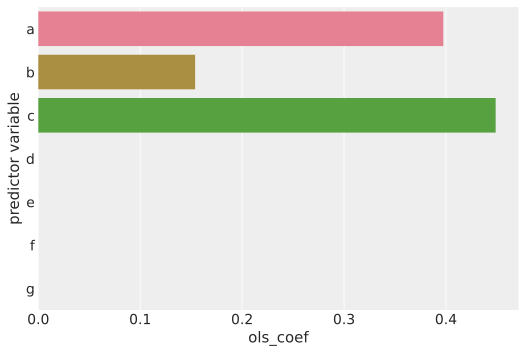

In [7]:
thing.plot_coeffs()

But we can see that (for this dataset) these estimates are quite bad. So we can lift the "sum to 1" assumption and instead use the `LinearRegression` model, but still constrain weights to be positive. Equally, you could experiment with the `Ridge` model (e.g. `Ridge(positive=True, alpha=100)`).

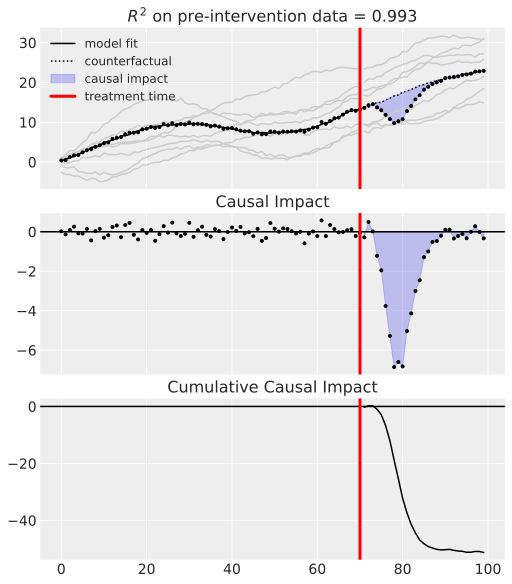

In [8]:
from causalpy.skl_experiments import SyntheticControl
from sklearn.linear_model import LinearRegression

# Note, we do not want an intercept in this model
thing = SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    prediction_model=LinearRegression(positive=True),
)

fig, ax = thing.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "synthetic_control_skl.svg",
        bbox_inches="tight",
        format="svg",
    )

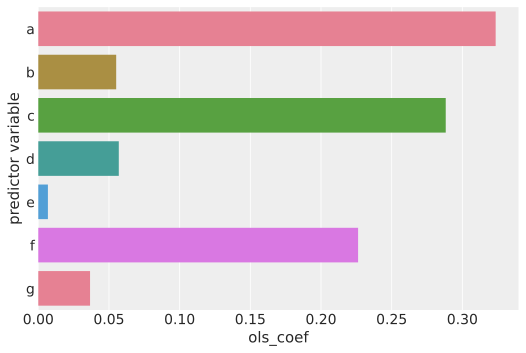

In [9]:
thing.plot_coeffs()

## Interrupted time series

In [10]:
its_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "its.csv"
df = pd.read_csv(its_data_path, parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")

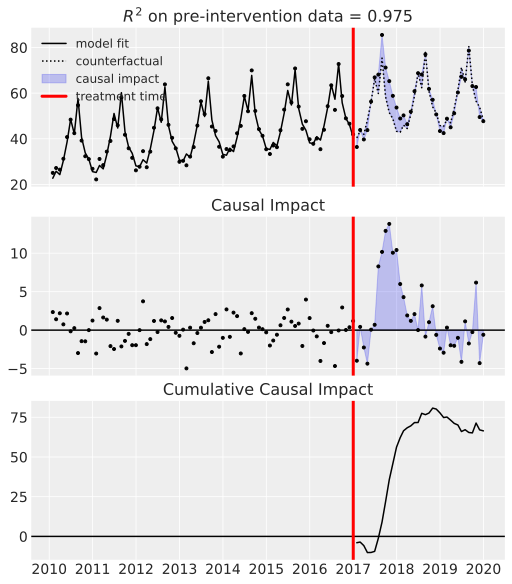

In [11]:
from causalpy.skl_experiments import InterruptedTimeSeries
from sklearn.linear_model import LinearRegression

thing = InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=LinearRegression(),
)

fig, ax = thing.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "interrupted_time_series_skl.svg",
        bbox_inches="tight",
        format="svg",
    )

## Difference in Differences

In [12]:
did_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "did.csv"
data = pd.read_csv(did_data_path)

/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


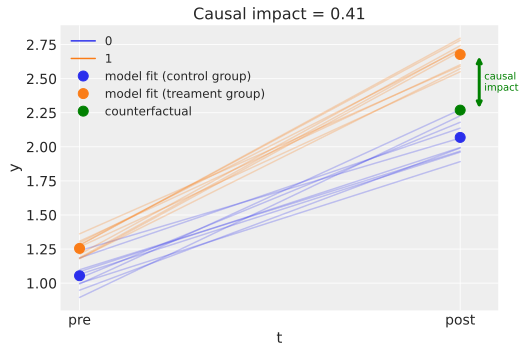

In [13]:
from causalpy.skl_experiments import DifferenceInDifferences
from sklearn.linear_model import LinearRegression

# NOTE: `treated` is a deterministic function of `t` and `group`. So add this function into the formula.

thing = DifferenceInDifferences(
    data,
    formula="y ~ 1 + group + t + treated:group",
    prediction_model=LinearRegression(),
)
fig, ax = thing.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "difference_in_differences_skl.svg",
        bbox_inches="tight",
        format="svg",
    )

## Regression discontinuity

In [14]:
rd_data_path = (
    pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "regression_discontinuity.csv"
)
data = pd.read_csv(rd_data_path)

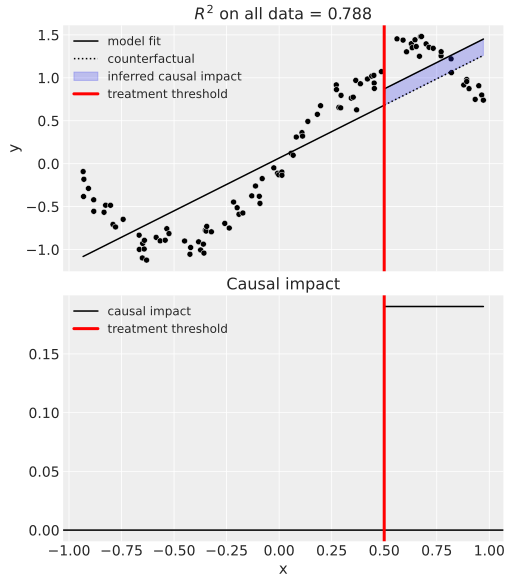

In [15]:
from causalpy.skl_experiments import RegressionDiscontinuity
from sklearn.linear_model import LinearRegression

thing = RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    prediction_model=LinearRegression(),
    treatment_threshold=0.5,
)
thing.plot();

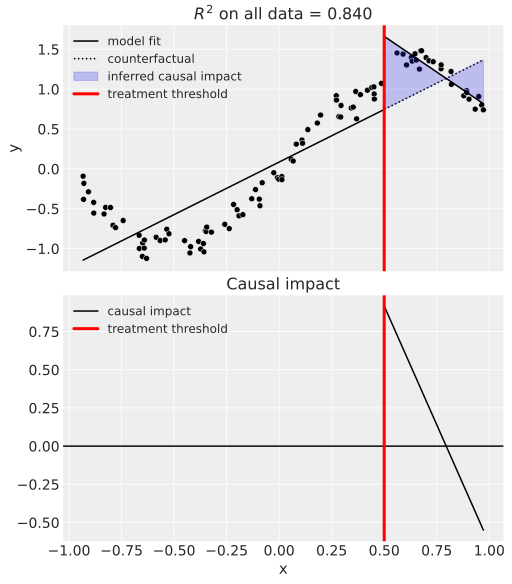

In [16]:
thing = RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    prediction_model=LinearRegression(),
    treatment_threshold=0.5,
)
thing.plot();

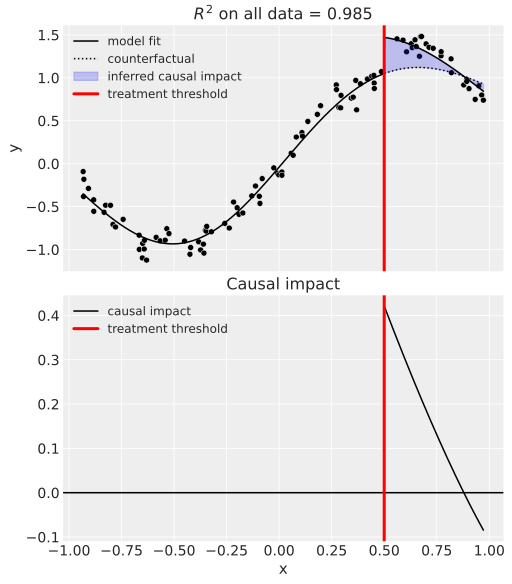

In [17]:
from causalpy.skl_experiments import RegressionDiscontinuity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

kernel = 1.0 * ExpSineSquared(1.0, 5.0) + WhiteKernel(1e-1)
thing = RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    prediction_model=GaussianProcessRegressor(kernel=kernel),
    treatment_threshold=0.5,
)
fig, ax = thing.plot();

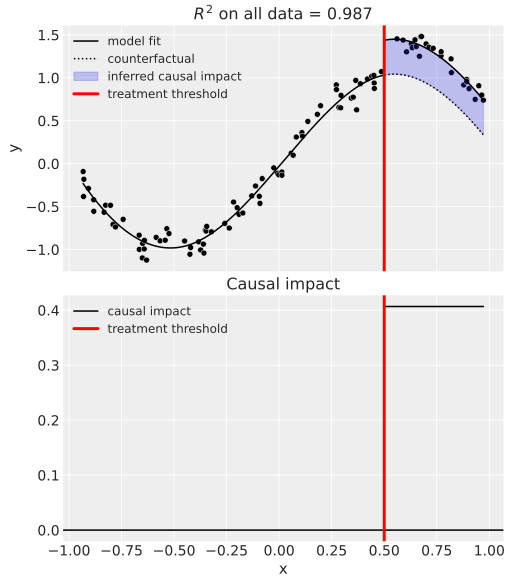

In [18]:
from causalpy.skl_experiments import RegressionDiscontinuity
from sklearn.linear_model import LinearRegression

# use basis splines
thing = RegressionDiscontinuity(
    data,
    formula="y ~ 1 + bs(x, df=6) + treated",
    prediction_model=LinearRegression(),
    treatment_threshold=0.5,
)
fig, ax = thing.plot()

if export_images:
    plt.savefig(
        pathlib.Path.cwd().parents[0] / "img" / "regression_discontinuity_skl.svg",
        bbox_inches="tight",
        format="svg",
    )

Run the 'drinking example' from the RDD chapter of [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html).

In [19]:
rd_data_path = pathlib.Path.cwd().parents[0] / "causalpy" / "data" / "drinking.csv"
df = pd.read_csv(rd_data_path)[["agecell", "all", "mva", "suicide"]]
df["agecell"] = df["agecell"] - 21
# create dummy variable
df = df.assign(treated=(df["agecell"] > 0))
# drop rows with missing data
df = df.dropna(axis=0)

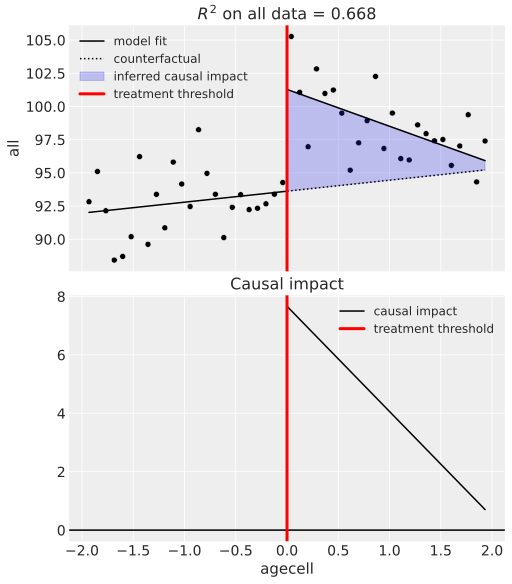

In [20]:
from causalpy.skl_experiments import RegressionDiscontinuity
from sklearn.linear_model import LinearRegression

thing = RegressionDiscontinuity(
    df,
    formula="all ~ 1 + agecell + treated + agecell:treated",
    running_variable_name="agecell",
    outcome_variable_name="all",
    prediction_model=LinearRegression(),
    treatment_threshold=0,
)
thing.plot();